# ThaiME Codebook for All v1 Projects

Data for all ThaiME v1 projects are obtained on 2020-07-09.

In [1]:
#download and installs for colab
!npx degit pnphannisa/thaimaimee -f
!pip install fuzzywuzzy python-Levenshtein -q
!pip install pythainlp -q

npx: installed 1 in 2.621s
> destination directory is not empty. Using --force, continuing
> cloned pnphannisa/thaimaimee#master
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 13.1MB 328kB/s 
     |████████████████████████████████| 747kB 53.3MB/s 


In [2]:
import numpy as np
import pandas as pd
import requests
import tqdm
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

def check_missing(df):
    per_missing = df.isnull().mean()
    missing_df = pd.DataFrame({'col': df.columns, 'per_missing': per_missing})
    missing_df = missing_df.sort_values('per_missing',ascending=False).reset_index(drop=True)
    missing_df['col'] = pd.Categorical(missing_df.col, categories=missing_df.col, ordered=True)
    return missing_df

In [3]:
# #from https://gist.github.com/korakot/01d181229b21411b0a20784e0ca20d3d
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib  
import matplotlib.font_manager as matfont
matfont.fontManager.addfont('thsarabunnew-webfont.ttf.1') # 3.2+
from plotnine import *
from mizani import *
theme_set(theme_minimal(14, 'TH Sarabun New'))

In [ ]:
# #for mac
# import matplotlib
# matplotlib.rc('font', family='Ayuthaya')

## Clean Data

In [55]:
thaime = pd.read_excel('data/thaime_v1.xlsx')
thaime.columns = ['plan_nb','project_name','budget','unit','ministry','province','created_date','details_url']
thaime.shape

(46422, 8)

In [56]:
def str_to_float(x):
    try:
        return float(str(x).replace(',',''))
    except Exception as e:
        return None

#convert to numbers
thaime['budget'] = thaime.budget.map(str_to_float)
thaime.budget.describe()

count    4.641600e+04
mean     3.120729e+07
std      1.373058e+09
min      8.700000e+03
25%      4.939750e+05
50%      1.000000e+06
75%      4.500000e+06
max      2.417580e+11
Name: budget, dtype: float64

In [57]:
#remove text artifacts
for c in ['project_name','unit','ministry','province','created_date','details_url']:
    #remove \
    thaime[c] = thaime[c].map(lambda x: str(x).strip().replace('\\',''))
    #replace \n with /
    thaime[c] = thaime[c].map(lambda x: str(x).strip().replace('\n','/'))
    #replace nan with None
    thaime[c] = thaime[c].map(lambda x: None if str(x) in ['nan','-','None'] else x)

In [59]:
#created date
def split_date(x):
    try:
        splitted = str(x).replace('00:00:00','').split('-')
        return f'{int(splitted[0])-543}-{splitted[1].zfill(2)}-{splitted[2].zfill(2)}'
    except Exception as e:
        return e
thaime['created_date'] = thaime.created_date.map(split_date)

In [62]:
#you can't really clean province
thaime.province.value_counts().reset_index().sort_values('province').head(10)

,index,province
165,50 ชุมชน,1
132,3 เขตพัฒนาการท่องเที่ยว,1
131,4 ภาค (กลาง เหนือ อีสาน ตะวันออก),1
130,55 จังหวัด,1
129,19 จังหวัด,1
128,"พื้นที่ป่าสงวนแห่งชาติ 9,000 หมู่บ้าน",1
127,5 จังหวัด (กทม. เชียงใหม่ ขอนแก่น ชลบุรี สงขลา),1
126,8 จังหวัด,1
125,11 จังหวัด,1
124,กลุ่มจังหวัดในภาคตะวันออกเฉียงเหนือ,1


In [63]:
#extract details url
def get_details_url(x):
    try:
        return BeautifulSoup(x).find('a').get('href')
    except:
        return x
thaime['details_url'] = thaime.details_url.map(get_details_url)

In [65]:
#handle ministries
ministries = pd.DataFrame(thaime.ministry.map(lambda x: x.replace('กระทรวง','') if x is not None else x)\
                          .value_counts()).reset_index()
ministries.columns = ['ministry','cnt']
ministries.head()

,ministry,cnt
0,มหาดไทย,42882
1,คมนาคม,897
2,เกษตรและสหกรณ์,891
3,การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม,433
4,ทรัพยากรธรรมชาติและสิ่งแวดล้อม,419


In [67]:
#create dictionary of duplicate ministry names
ministry_dict = {}
for m in ministries.ministry:
    i=0
    for k in ministry_dict.keys():
        if fuzz.ratio(m,k)>95:
            i+=1
            ministry_dict[k]+=f'|{m}'
    if i==0: ministry_dict[m]=m

In [68]:
#replace with corrected name
correct_dict = {}
for k,v in ministry_dict.items():
    vs = v.split('|')
    for v_ in vs:
        correct_dict[v_] = k

thaime['ministry'] = thaime.ministry.map(lambda x: x.replace('กระทรวง','') if x is not None else x)\
    .map(lambda x: correct_dict[x] if x is not None else x)
thaime.ministry.value_counts().head()

มหาดไทย                                      42882
คมนาคม                                       897  
เกษตรและสหกรณ์                               891  
การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม    460  
ทรัพยากรธรรมชาติและสิ่งแวดล้อม               420  
Name: ministry, dtype: int64

In [69]:
ministry_df = pd.DataFrame.from_dict(ministry_dict,orient='index').reset_index()
ministry_df.columns = ['key','val']
ministry_df['nb_val'] = ministry_df.val.map(lambda x: len(x.split('|')))
ministry_df = ministry_df.sort_values('nb_val',ascending=False).reset_index(drop=True)
for i,row in ministry_df.head(5).iterrows():
    print(f"Ministry name: {row['key']}")
    print(f"Variations: {row['val']}")
    print('-------------------------------------')

Ministry name: การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม
Variations: การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม|การอุดมศึกษา วิทยาศาสตร์ วิจัย และนวัตกรรม|อุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม
-------------------------------------
Ministry name: ทรัพยากรธรรมชาติและสิ่งแวดล้อม
Variations: ทรัพยากรธรรมชาติและสิ่งแวดล้อม|ทัพยากรธรรมชาติละสิ่งแวดล้อม
-------------------------------------
Ministry name: มหาดไทย
Variations: มหาดไทย
-------------------------------------
Ministry name: มหาวิทยาลัยเกษตรศาสตร์
Variations: มหาวิทยาลัยเกษตรศาสตร์
-------------------------------------
Ministry name: มหาดไทย/เกษตรและสหกรณ์
Variations: มหาดไทย/เกษตรและสหกรณ์
-------------------------------------


In [70]:
#handle units
units = pd.DataFrame(thaime.unit.map(lambda x: x if x is not None else x)\
                          .value_counts()).reset_index()
units.columns = ['unit','cnt']
units.head()

,unit,cnt
0,กรมส่งเสริมการปกครองท้องถิ่น,25672
1,กรมส่งเสริมการปกครองส่วนท้องถิ่น,4012
2,จังหวัดร้อยเอ็ด,1916
3,จังหวัดอุดรธานี,1805
4,การประปาส่วนภูมิภาค,1237


In [72]:
#create dictionary of duplicate unit names
unit_dict = {}
for m in units.unit:
    i=0
    for k in unit_dict.keys():
        if fuzz.ratio(m,k)>95:
            i+=1
            unit_dict[k]+=f'|{m}'
    if i==0: unit_dict[m]=m

In [73]:
#replace with corrected name
correct_dict = {}
for k,v in unit_dict.items():
    vs = v.split('|')
    for v_ in vs:
        correct_dict[v_] = k

thaime['unit'] = thaime.unit.map(lambda x: correct_dict[x] if x is not None else x)
thaime.unit.value_counts().head()

กรมส่งเสริมการปกครองท้องถิ่น        25672
กรมส่งเสริมการปกครองส่วนท้องถิ่น    4012 
จังหวัดร้อยเอ็ด                     1916 
จังหวัดอุดรธานี                     1805 
การประปาส่วนภูมิภาค                 1251 
Name: unit, dtype: int64

In [74]:
unit_df = pd.DataFrame.from_dict(unit_dict,orient='index').reset_index()
unit_df.columns = ['key','val']
unit_df['nb_val'] = unit_df.val.map(lambda x: len(x.split('|')))
unit_df = unit_df.sort_values('nb_val',ascending=False).reset_index(drop=True)
for i,row in unit_df.head(5).iterrows():
    print(f"Unit name: {row['key']}")
    print(f"Variations: {row['val']}")
    print('-------------------------------------')

Unit name: กรมอุทยานแห่งชาติ สัตว์ป่า และพันธุ์พืช
Variations: กรมอุทยานแห่งชาติ สัตว์ป่า และพันธุ์พืช|กรมอุทยานแห่งชาติ สัตว์ป่าและพันธุ์พืช|กรมอุทยานแห่งชาติสัตว์ป่า และพันธุ์พืช|กรมอุทยานแห่งชาติ /สัตว์ป่า และพันธุ์พืช|กรมอุทยานแห่งชาติสัตว์ป่าและพันธุ์พืช
-------------------------------------
Unit name: องค์การบริหารการพัฒนาพื้นที่พิเศษเพื่อการท่องเที่ยวอย่างยั่งยืน (องค์การมหาชน)
Variations: องค์การบริหารการพัฒนาพื้นที่พิเศษเพื่อการท่องเที่ยวอย่างยั่งยืน (องค์การมหาชน)|องค์การบริหารการพัฒนาพื้นที่พิเศษเพื่อการท่องเที่ยวอย่างยั่งยืน(องค์การมหาชน)|องค์การบริหารการพัฒนา พื้นที่พิเศษเพื่อการท่องเที่ยวอย่างยั่งยืน (องค์การมหาชน)
-------------------------------------
Unit name: สำนักงานปลัดกระทรวงการท่องเที่ยวและกีฬา
Variations: สำนักงานปลัดกระทรวงการท่องเที่ยวและกีฬา|สำนักงานปลัดกระทรวงท่องเที่ยวและกีฬา|สำนักปลัดกระทรวงการท่องเที่ยวและกีฬา
-------------------------------------
Unit name: องค์การสวนสัตว์ ในพระบรมราชูปถัมภ์
Variations: องค์การสวนสัตว์ ในพระบรมราชูปถัมภ์|องค์การสวนสัตว์ใน

In [75]:
# thaime.to_csv('data/thaimaimee_v1.csv',index=False)

## Explore

In [76]:
thaime = pd.read_csv('data/thaimaimee_v1.csv')
thaime['budget_g'] = thaime.budget/1e9
thaime.head()

,plan_nb,project_name,budget,unit,ministry,province,created_date,details_url,budget_g
0,3.1,โครงการพื้นที่ท่องที่ยวปลอดภัยสำหรับนักท่องเที่ยว (Safety Zone),10000000.0,กรมการท่องเที่ยว,การท่องเที่ยวและกีฬา,NaN,2020-06-06,https://drive.google.com/file/d/1bOhpEJIvrTCc91jJQyEv3sYKr9edlIVC/view?usp=sharing,0.010000
1,3.1,พัฒนาระบบโครงสร้างพื้นฐานด้านการท่องเที่ยวเพื่อรองรับการให้บริการ และการ เข้าเยี่ยมชมแหล่งเรียนรู้และแหล่งท่องเที่ยวภายในสวนพฤกษศาสตร์พื้นที่ดำเนินการ,24046400.0,องค์การสวนพฤกษศาสตร์,ทรัพยากรธรรมชาติและสิ่งแวดล้อม,NaN,2020-06-06,https://drive.google.com/file/d/1_6PI027oKv9z5-bypJb0FEMg1t93el3l/view?usp=sharing,0.024046
2,3.1,การแปลงเครื่องจักรเป็นทุนโดยการบำรุงรักษาเครื่องจักรสำหรับโรงงานอุตสาหกรรมที่ได้รับผลกระทบจากสถานการณ์การระบาดของไวรัสโคโรนา 2019 กลุ่มที่ 1,40000000.0,กรมโรงงานอุตสาหกรรม,อุตสาหกรรม,NaN,2020-06-06,https://drive.google.com/file/d/1nfaJkK6XXR3to9ZpjS5HryN740u94xc6/view?usp=sharing,0.040000
3,3.1,การแปลงเครื่องจักรเป็นทุนโดยการบำรุงรักษาเครื่องจักรสำหรับโรงงานอุตสาหกรรมที่ได้รับผลกระทบจากสถานการณ์การระบาดของไวรัสโคโรนา 2019 กลุ่มที่ 2,40000000.0,กรมโรงงานอุตสาหกรรม,อุตสาหกรรม,NaN,2020-06-06,https://drive.google.com/file/d/1E0nLPJ4OrcexTpmX6Dv78l3mWAYLbnG0/view?usp=sharing,0.040000
4,3.1,"โครงการกำหนดแนวทางการออกแบบ ""เมืองท่องเที่ยว"" บนฐานอัตลักษณ์ ศักยภาพ และความพร้อมของพื้นที่",50000000.0,กรมการท่องเที่ยว,การท่องเที่ยวและกีฬา,NaN,2020-06-06,https://drive.google.com/file/d/1hA9MvOTkoRagMU-ExYk8kahz-EvvZoe6/view?usp=sharing,0.050000


### Missing Data

In [77]:
#some missing data but not too many
check_missing(thaime)

,col,per_missing
0,details_url,0.310564
1,province,0.001228
2,ministry,0.000280
3,project_name,0.000258
4,budget,0.000129
5,budget_g,0.000129
6,unit,0.000043
7,plan_nb,0.000000
8,created_date,0.000000


### Budget Breakdown by Ministry

In [78]:
bbm = pd.DataFrame(thaime.groupby('ministry').budget_g.sum()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm['ministry_'] = bbm.apply(lambda row: 'อื่นๆ' if row['budget_g']<3 else row['ministry'],1)
bbm2 = bbm.groupby('ministry_').budget_g.sum().reset_index().sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm2['ministry_'] = pd.Categorical(bbm2.ministry_, categories=bbm2.ministry_,ordered=True)
bbm2.head()

,ministry_,budget_g
0,เกษตรและสหกรณ์,468.169851
1,มหาดไทย,298.088299
2,คมนาคม,204.237680
3,สำนักนายกรัฐมนตรี,202.908973
4,การคลัง,55.000200


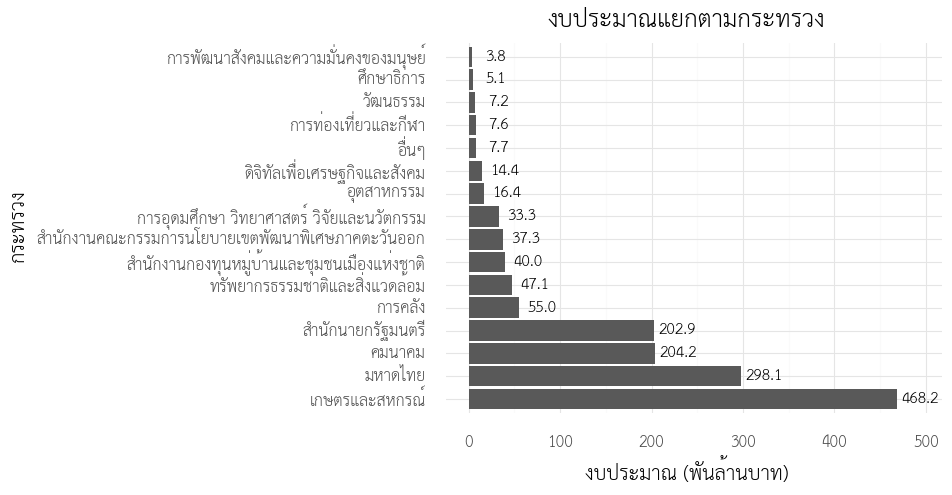

<ggplot: (8793361284044)>

In [81]:
g = (ggplot(bbm2, aes(x='ministry_',y='budget_g')) + geom_col() +
     xlab('กระทรวง') + ylab('งบประมาณ (พันล้านบาท)') +
     geom_text(aes(x='ministry_',y='budget_g+25',label='round(budget_g,1)')) +
     coord_flip() + ggtitle('งบประมาณแยกตามกระทรวง'))
g

In [ ]:
# bbm['thailand'] = 'thailand'
# fig = px.treemap(bbm, path=['thailand','ministry'], 
#                  values='budget_g',
#                   color='budget_g',
#                   color_continuous_scale='RdBu',
#                   color_continuous_midpoint=bbm.budget_g.quantile(0.95))
# fig.update_layout(uniformtext=dict(minsize=20, mode=False))
# fig.show()

## Number of Projects by Ministry

In [82]:
bbm = pd.DataFrame(thaime.groupby('ministry').budget_g.count()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm['ministry_'] = bbm.apply(lambda row: 'อื่นๆ' if row['budget_g']<30000 else row['ministry'],1)
bbm2 = bbm.groupby('ministry_').budget_g.sum().reset_index().sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm2['ministry_'] = pd.Categorical(bbm2.ministry_, categories=bbm2.ministry_,ordered=True)
bbm2.head()

,ministry_,budget_g
0,มหาดไทย,42878
1,อื่นๆ,3525


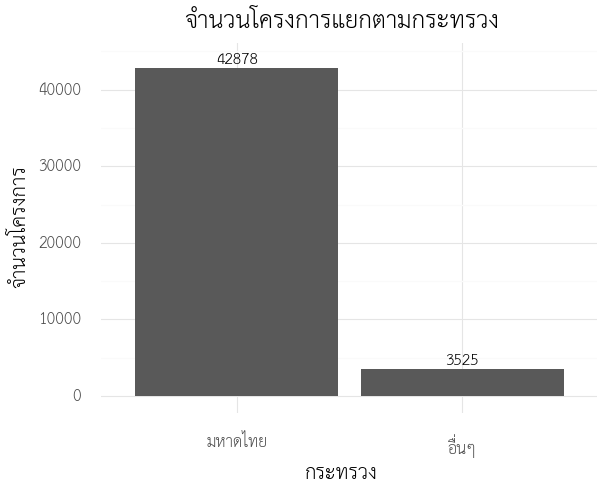

<ggplot: (8793359659854)>

In [83]:
g = (ggplot(bbm2, aes(x='ministry_',y='budget_g')) + geom_col() +
     xlab('กระทรวง') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='ministry_',y='budget_g+1000',label='round(budget_g,1)')) +
     ggtitle('จำนวนโครงการแยกตามกระทรวง'))
g

### Top Projects

In [84]:
bbm = pd.DataFrame(thaime.groupby(['project_name','ministry']).budget_g.sum()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True).head(10)
bbm

,project_name,ministry,budget_g
0,โครงการพัฒนาธุรกิจบริการดินและปุ๋ยเพื่อชุมชน (One Stop Service),เกษตรและสหกรณ์,241.999758
1,โครงการพลิกฟื้นธุรกิจ SME ที่เป็น NPL ให้กลับมาดำเนินธุรกิจได้,สำนักนายกรัฐมนตรี,100.000000
2,โครงการพัฒนาทางหลวงเชิงพื้นที่,คมนาคม,63.106734
3,โครงการเศรษฐกิจพอเพียงสร้างไทย,การคลัง,55.000000
4,โครงการฟื้นฟูศักยภาพการดำเนินธุรกิจสำหรับ SME ที่ไม่สามารถเข้าถึงแหล่งเงินทุน,สำนักนายกรัฐมนตรี,50.000000
5,โครงการพัฒนาแหล่งน้ำ บริหารจัดการน้ำ และเพิ่มพื้นที่ชลประทาน,เกษตรและสหกรณ์,42.235954
6,โครงการยกระดับเศรษฐกิจชุมชนด้วยการสร้างงาน สร้างอาชีพ และสร้างรายได้ เพื่อบรรเทาผลกระทบทางเศรษฐกิจจากการระบาดของโรคติดเชื้อไวรัสโคโรนา 2019,สำนักงานกองทุนหมู่บ้านและชุมชนเมืองแห่งชาติ,40.000000
7,โครงการก่อสร้างกำแพงคอนกรีตหุ้มด้วยแผ่นยางธรรมชาติ,คมนาคม,38.477292
8,โครงการที่สอดคล้องกับแนวทางการจัดทำข้อเสนอฯ (4กลุ่มงาน),สำนักงานคณะกรรมการนโยบายเขตพัฒนาพิเศษภาคตะวันออก,36.938373
9,โครงการพัฒนาแหล่งน้ำและพื้นที่ชลประทาน,เกษตรและสหกรณ์,33.434693


### Project Size Distribution

In [85]:
thaime['digits'] = thaime.budget.map(lambda x: len(str(round(x))) if x==x else x)
dg = thaime.groupby('digits').project_name.count().reset_index()
dg

,digits,project_name
0,4.0,1
1,5.0,617
2,6.0,22425
3,7.0,17791
4,8.0,4936
5,9.0,538
6,10.0,73
7,11.0,21
8,12.0,2


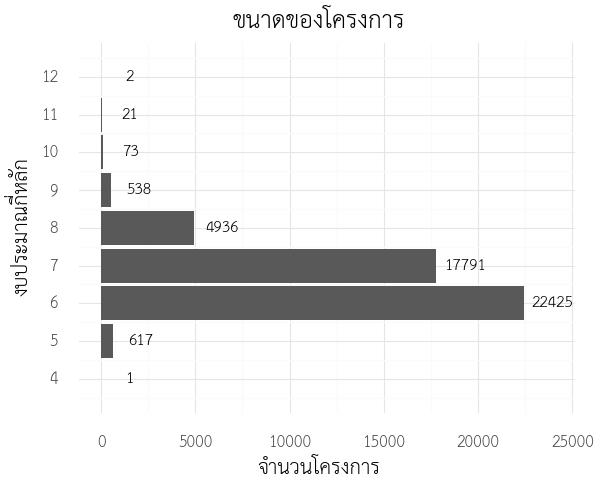

<ggplot: (-9223363243495221318)>

In [87]:
g = (ggplot(dg, aes(x='digits',y='project_name')) + geom_col() +
     xlab('งบประมาณกี่หลัก') + ylab('จำนวนโครงการ') +
     scale_x_continuous(breaks=[i for i in range(13)])+
     geom_text(aes(x='digits',y='project_name+1500',label='round(project_name,1)')) +
     coord_flip() + ggtitle('ขนาดของโครงการ'))
g

### Project Size by Ministry

In [88]:
bbm = pd.DataFrame(thaime.groupby('ministry').budget_g.sum()).reset_index().\
    sort_values('budget_g',ascending=False).reset_index(drop=True)
bbm['ministry_'] = bbm.apply(lambda row: 'อื่นๆ' if row['budget_g']<3 else row['ministry'],1)
top_ministries = list(bbm.ministry_[:12])
top_ministries

['เกษตรและสหกรณ์',
 'มหาดไทย',
 'คมนาคม',
 'สำนักนายกรัฐมนตรี',
 'การคลัง',
 'ทรัพยากรธรรมชาติและสิ่งแวดล้อม',
 'สำนักงานกองทุนหมู่บ้านและชุมชนเมืองแห่งชาติ',
 'สำนักงานคณะกรรมการนโยบายเขตพัฒนาพิเศษภาคตะวันออก',
 'การอุดมศึกษา วิทยาศาสตร์ วิจัยและนวัตกรรม',
 'อุตสาหกรรม',
 'ดิจิทัลเพื่อเศรษฐกิจและสังคม',
 'การท่องเที่ยวและกีฬา']

In [89]:
thaime2 = thaime.copy()
thaime2['ministry'] = thaime2.ministry.map(lambda x: 'อื่นๆ' if x not in top_ministries else x)

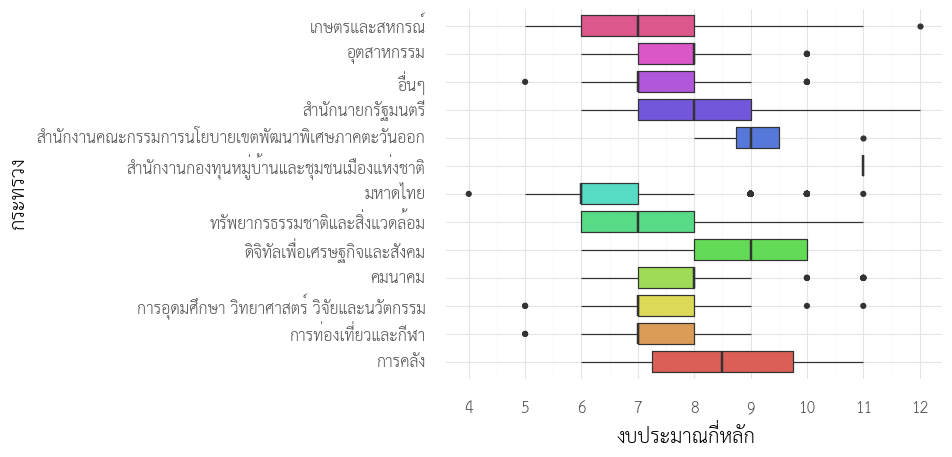

<ggplot: (-9223363243495242517)>

In [90]:
g = (ggplot(thaime2, aes(x='ministry',y='digits',fill='ministry')) + geom_boxplot() +
    theme(legend_position='none') + xlab('กระทรวง') + ylab('งบประมาณกี่หลัก') +
    scale_y_continuous(breaks=[i for i in range(13)])+
    coord_flip())
g

### Project Name Word Cloud

In [91]:
import pythainlp
from pythainlp.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [92]:
texts = []
for i in range(thaime.shape[0]):
    texts+=[i for i in word_tokenize(thaime.project_name[i], keep_whitespace=False) if len(i)>2]
text = ' '.join(texts)
text[:100]

'โครงการ พื้นที่ ท่อง ที่ ปลอดภัย สำหรับ นักท่องเที่ยว Safety Zone พัฒนา ระบบ โครงสร้างพื้นฐาน ด้าน ก'

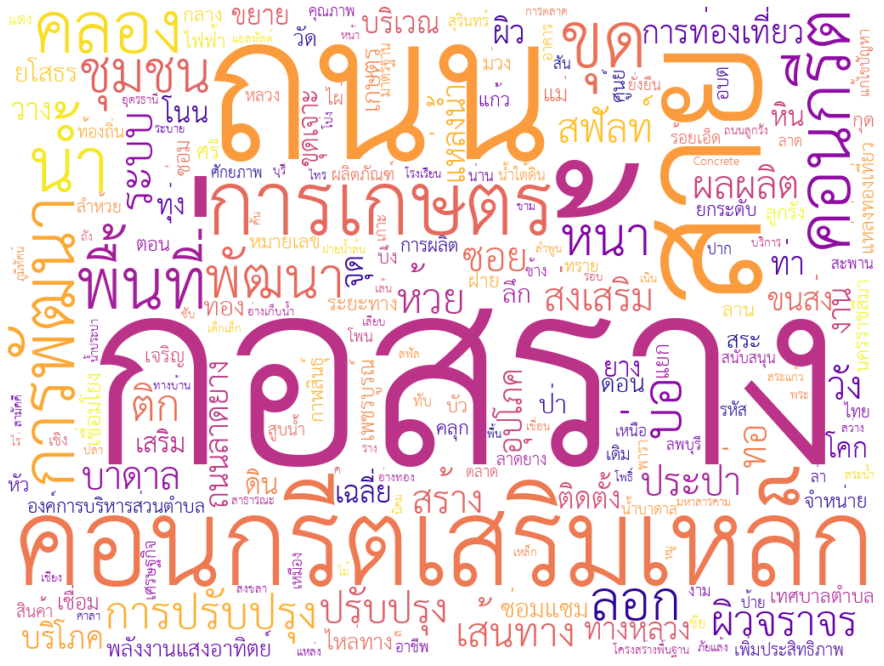

In [93]:
wordcloud = WordCloud(font_path='thsarabunnew-webfont.ttf.1',
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=200,
                      collocations=False,
                      colormap='plasma',
                      regexp=r"[ก-๙a-zA-Z']+",
                      stopwords=list(pythainlp.corpus.common.thai_stopwords()) + \
                          ['โครงการ','โครง',
                           #units
                          'เมตร','ตารางเมตร','ลบ','ตร','กม',
                           #area
                          'จังหวัด','เขต','อำเภอ','ตำบล','หมู่','บ้าน','เมือง',
                           'หมู่บ้าน','หนอง',
                           #size
                           'ขนาด','จำนวน','ปริมาณ']
                      ).generate(text)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

### Projects with Specific Keywords: Constructions, Roads and Canels

In [94]:
constructions = ['ก่อสร้าง','คอนกรีต']
roads = ['ถนน','ทางหลวง','อัสฟัล','ผิวจราจร']
canels = ['คลอง','ขุดลอก']

thaime['constructions'] = thaime.project_name.map(lambda x: 'ใช่' if any([i in str(x) for i in constructions]) else 'ไม่ใช่')
thaime['roads'] = thaime.project_name.map(lambda x: 'ใช่' if any([i in str(x) for i in roads]) else 'ไม่ใช่')
thaime['canels'] = thaime.project_name.map(lambda x: 'ใช่' if any([i in str(x) for i in canels]) else 'ไม่ใช่')

In [95]:
bbm = pd.DataFrame(thaime.groupby('constructions').budget_g.agg([sum,len])).reset_index().\
    sort_values('sum',ascending=False).reset_index(drop=True)
bbm

,constructions,sum,len
0,ไม่ใช่,1317.997584,26251.0
1,ใช่,130.519790,20171.0


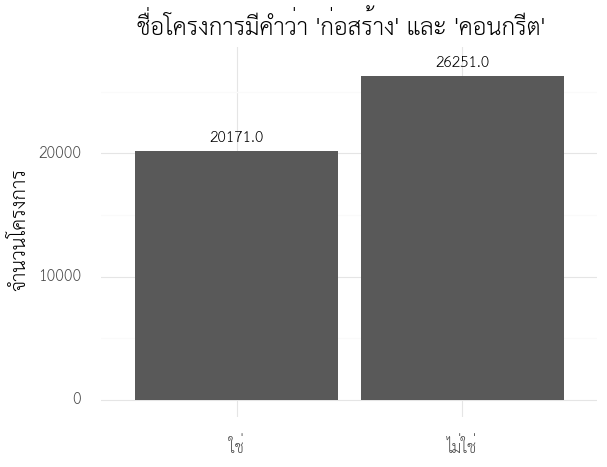

<ggplot: (8793345166635)>

In [96]:
g = (ggplot(bbm, aes(x='constructions',y='len')) + geom_col() +
     xlab('') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='constructions',y='len+1000',label='len')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ก่อสร้าง' และ 'คอนกรีต'"))
g

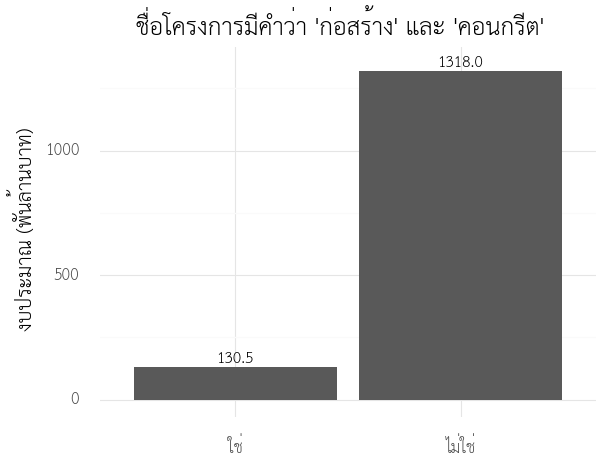

<ggplot: (8793345147463)>

In [97]:
g = (ggplot(bbm, aes(x='constructions',y='sum')) + geom_col() +
     xlab('') + ylab('งบประมาณ (พันล้านบาท)') +
     geom_text(aes(x='constructions',y='sum+30',label='round(sum,1)')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ก่อสร้าง' และ 'คอนกรีต'"))
g

In [98]:
bbm = pd.DataFrame(thaime.groupby('roads').budget_g.agg([sum,len])).reset_index().\
    sort_values('sum',ascending=False).reset_index(drop=True)
bbm

,roads,sum,len
0,ไม่ใช่,1215.996845,27439.0
1,ใช่,232.520529,18983.0


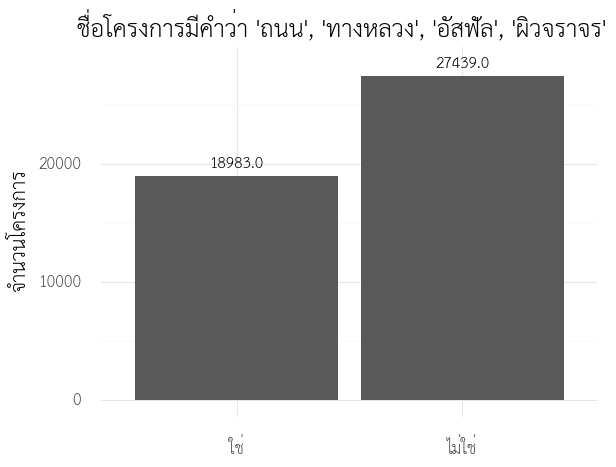

<ggplot: (-9223363243495355213)>

In [99]:
g = (ggplot(bbm, aes(x='roads',y='len')) + geom_col() +
     xlab('') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='roads',y='len+1000',label='len')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ถนน', 'ทางหลวง', 'อัสฟัล', 'ผิวจราจร'"))
g

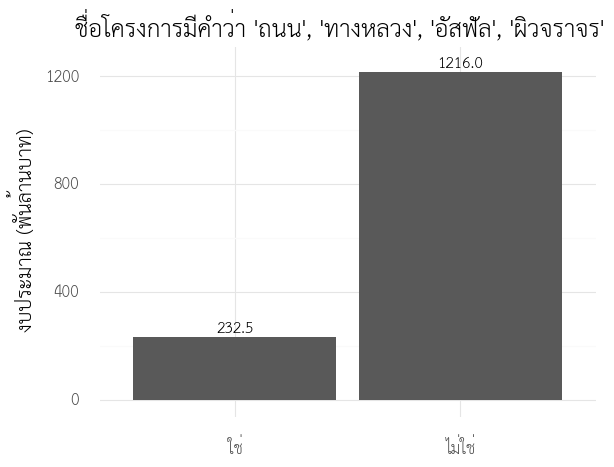

<ggplot: (-9223363243514037381)>

In [100]:
g = (ggplot(bbm, aes(x='roads',y='sum')) + geom_col() +
     xlab('') + ylab('งบประมาณ (พันล้านบาท)') +
     geom_text(aes(x='roads',y='sum+30',label='round(sum,1)')) +
     ggtitle("ชื่อโครงการมีคำว่า 'ถนน', 'ทางหลวง', 'อัสฟัล', 'ผิวจราจร'"))
g

In [101]:
bbm = pd.DataFrame(thaime.groupby('canels').budget_g.agg([sum,len])).reset_index().\
    sort_values('sum',ascending=False).reset_index(drop=True)
bbm

,canels,sum,len
0,ไม่ใช่,1418.941648,40012.0
1,ใช่,29.575725,6410.0


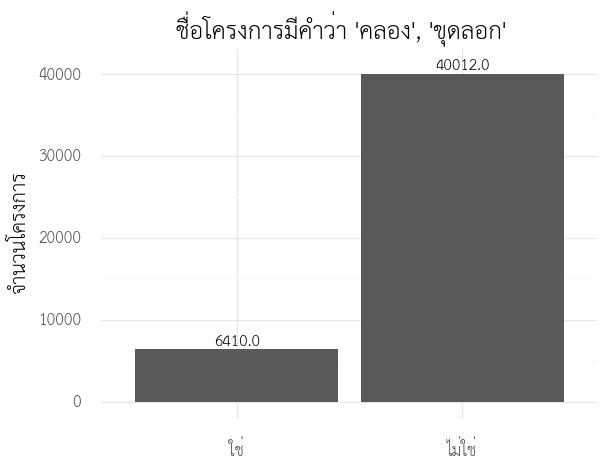

<ggplot: (8793340731645)>

In [102]:
g = (ggplot(bbm, aes(x='canels',y='len')) + geom_col() +
     xlab('') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='canels',y='len+1000',label='len')) +
     ggtitle("ชื่อโครงการมีคำว่า 'คลอง', 'ขุดลอก'"))
g

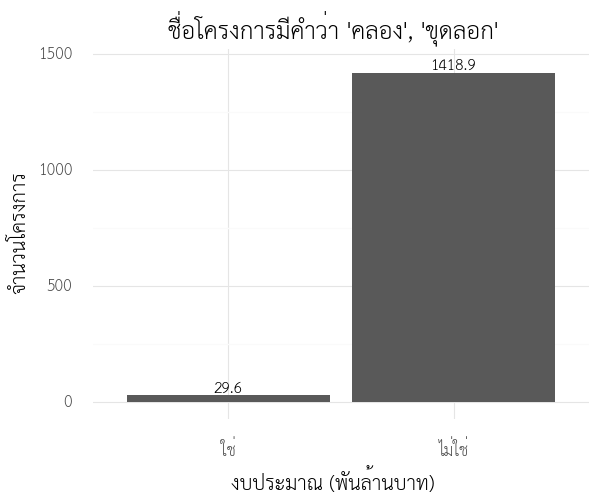

<ggplot: (-9223363243512992687)>

In [103]:
g = (ggplot(bbm, aes(x='canels',y='sum')) + geom_col() +
     xlab('งบประมาณ (พันล้านบาท)') + ylab('จำนวนโครงการ') +
     geom_text(aes(x='canels',y='sum+30',label='round(sum,1)')) +
     ggtitle("ชื่อโครงการมีคำว่า 'คลอง', 'ขุดลอก'"))
g